In [5]:

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import os
import shutil


In [6]:
device = torch.device("cuda:0") 

In [7]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = r'C:\Users\user\python\FacialClassification'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train','resize_600'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=8, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=8, shuffle=True, num_workers=1)

print('학습 데이터셋 크기:', len(train_datasets))
# print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 138112
클래스: ['embarass', 'pleasure', 'rage', 'sad']


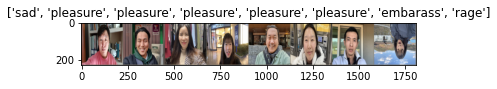

In [8]:
def imshow(input, title):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title)
    plt.show()


iterator = iter(train_dataloader)

inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [9]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
num_epochs = 12
model.train()
start_time = time.time()

best_model = model
best_accuray = 0.0


for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0
    epoch_start_time=time.time()

    full_len=len(train_dataloader)
    p=0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        p+=1
        p_rate=round(p/full_len,4)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        time_lapse=round(time.time()-epoch_start_time, 1)
        estimated_remain_time=round(time_lapse/p_rate-time_lapse,1)
        print('\r', '                                                                                                             ', end='')
        
        print('\r', f'epoch : {epoch} / {num_epochs}, {round(p_rate*100, 2)}% , time_lapse : {time_lapse}, estimated_remain_time : {estimated_remain_time}', end='')

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    if best_accuray < running_corrects :
        torch.save(best_model.state_dict(), f'best_{epoch}_{running_corrects}.model')
        torch.save(best_model.state_dict(), f'best_model_{epoch}_{running_corrects}.pth')

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
    
print ("The best model has an accuracy of " + str(best_accuray))
torch.save(best_model.state_dict(), 'best_1.model')
torch.save(best_model.state_dict(), 'best_model_1.pth')

 epoch : 0 / 12, 100.0% , time_lapse : 1967.8, estimated_remain_time : 0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

KeyboardInterrupt: 

In [8]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])
        print(preds)

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

The best model has an accuracy of tensor(3971, device='cuda:0')
